# Additional Tasks

### Import Neccessary Libraries

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


### Data Loading and Preprocessing

In [4]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['test', 'validation', 'train'],
    shuffle_files=True,
    as_supervised=True,  # Include labels
    with_info=True
)
print(f"Dataset Info:\n{ds_info}")
num_classes = ds_info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

Dataset Info:
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/da

I0000 00:00:1731599239.044913    3267 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21769 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [5]:
IMG_SIZE = 224  # You can adjust this size
BATCH_SIZE = 64  # You can adjust this size

def preprocess(image, label):
    # Resize and normalize images
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize to [0,1]
    return image, label


In [6]:
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_unbatched = ds_train
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Load Model

In [7]:
loaded_model = keras.models.load_model('flower_classification_model.keras')
loaded_test_loss, loaded_test_accuracy = loaded_model.evaluate(ds_test)
print(f'Loaded Model Test Accuracy: {loaded_test_accuracy*100:.4f}')

2024-11-14 23:47:33.849158: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1731599254.187446    3956 cuda_dnn.cc:529] Loaded cuDNN version 90300


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.7103 - loss: 1.3737
Loaded Model Test Accuracy: 69.8039


## Using Few-shot learning

### Reduce training data

In [8]:
subset_fraction = 0.25 # Fraction of the training data to use
ds_train_subset = ds_train.take(int(len(ds_train) * subset_fraction))

### Training

In [9]:
# Reinitialize the model (to ensure fair comparison)
model_subset = models.clone_model(loaded_model)
model_subset.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=50, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(
        'best_model.keras', save_best_only=True),
]

In [11]:
# Train on subset
epochs = 250  # Adjust the number of epochs as needed

history_subset = model_subset.fit(
    ds_train_subset,
    validation_data=ds_val,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - accuracy: 0.0154 - loss: 5.7681 - val_accuracy: 0.0098 - val_loss: 4.6299
Epoch 2/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.0293 - loss: 4.5697 - val_accuracy: 0.0098 - val_loss: 4.7565
Epoch 3/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.0325 - loss: 4.5387 - val_accuracy: 0.0098 - val_loss: 4.6705
Epoch 4/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.0465 - loss: 4.4845 - val_accuracy: 0.0098 - val_loss: 4.8066
Epoch 5/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.0332 - loss: 4.4749 - val_accuracy: 0.0098 - val_loss: 4.7547
Epoch 6/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.0464 - loss: 4.4369 - val_accuracy: 0.0098 - val_loss: 4.7337
Epoch 7/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.0509 - loss: 4.4083 - val_accuracy: 0.0098 - val_loss: 4.7139
Epoch 8/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.0431 - loss: 4.4117 - val_acc

In [12]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

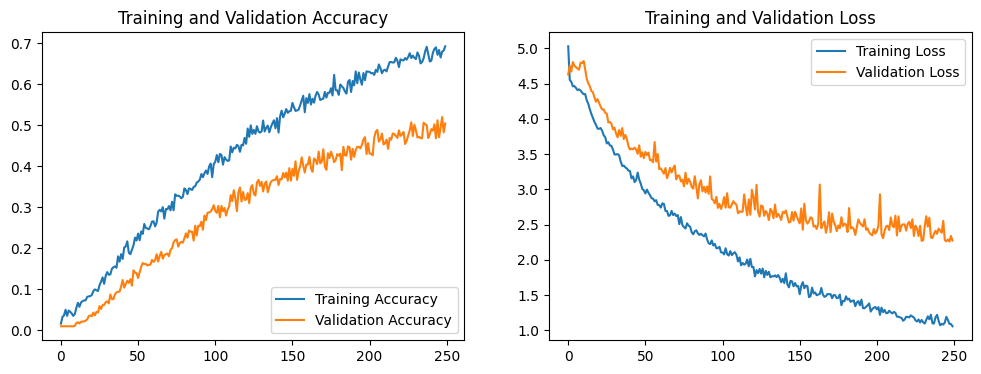

In [13]:
plot_history(history_subset)

### Evaluation

In [14]:
# Evaluate
test_loss, test_accuracy = model_subset.evaluate(ds_test)
print(f"Test Accuracy with {int(subset_fraction*100)}% training data: {test_accuracy*100:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5143 - loss: 2.1692
Test Accuracy with 25% training data: 50.7843
